In [107]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress = True)
from importlib import reload
import functions
from functions import *
import arithmetic
from arithmetic import *
functions = reload(functions)
arithmetic = reload(arithmetic)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
b = 3
qasm_qc = QuantumCircuit(b, b)
QFT(qasm_qc, b, delta=8)
qasm_output = qasm_qc.qasm()

In [30]:
with open("qasm_files/qasm{}qubit".format(b), 'w') as txt_file:
    txt_file.write(qasm_output)

In [ ]:
n_low = 2
n_high = 32
compareFTs(n_low, n_high, backend="statevector", display_bool=False)

errors2-32.txt
n=2, i=0
progress: 50.00%
--- 0.010s seconds ---
n=3, i=1
progress: 33.33%
progress: 66.67%
--- 0.038s seconds ---
n=4, i=2
progress: 25.00%
progress: 50.00%
progress: 75.00%
--- 0.085s seconds ---
n=5, i=3
progress: 20.00%
progress: 40.00%
progress: 60.00%
progress: 80.00%
--- 0.179s seconds ---
n=6, i=4
progress: 16.67%
progress: 33.33%
progress: 50.00%
progress: 66.67%
progress: 83.33%
--- 0.301s seconds ---
n=7, i=5
progress: 14.29%
progress: 28.57%
progress: 42.86%
progress: 57.14%
progress: 71.43%
progress: 85.71%
--- 0.476s seconds ---
n=8, i=6
progress: 12.50%
progress: 25.00%
progress: 37.50%
progress: 50.00%
progress: 62.50%
progress: 75.00%
progress: 87.50%
--- 0.797s seconds ---
n=9, i=7
progress: 11.11%
progress: 22.22%
progress: 33.33%
progress: 44.44%
progress: 55.56%
progress: 66.67%
progress: 77.78%
progress: 88.89%
--- 1.109s seconds ---
n=10, i=8
progress: 10.00%
progress: 20.00%
progress: 30.00%
progress: 40.00%
progress: 50.00%
progress: 60.00%
progr

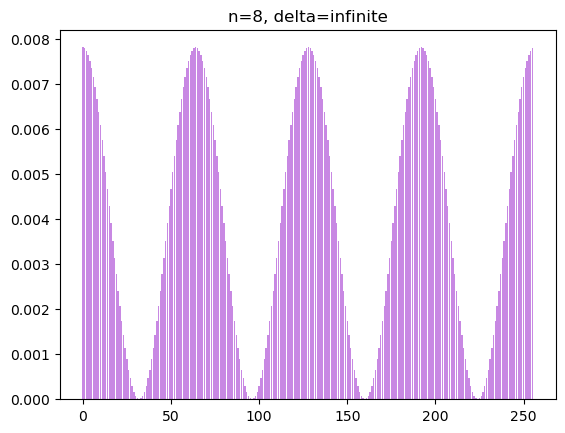

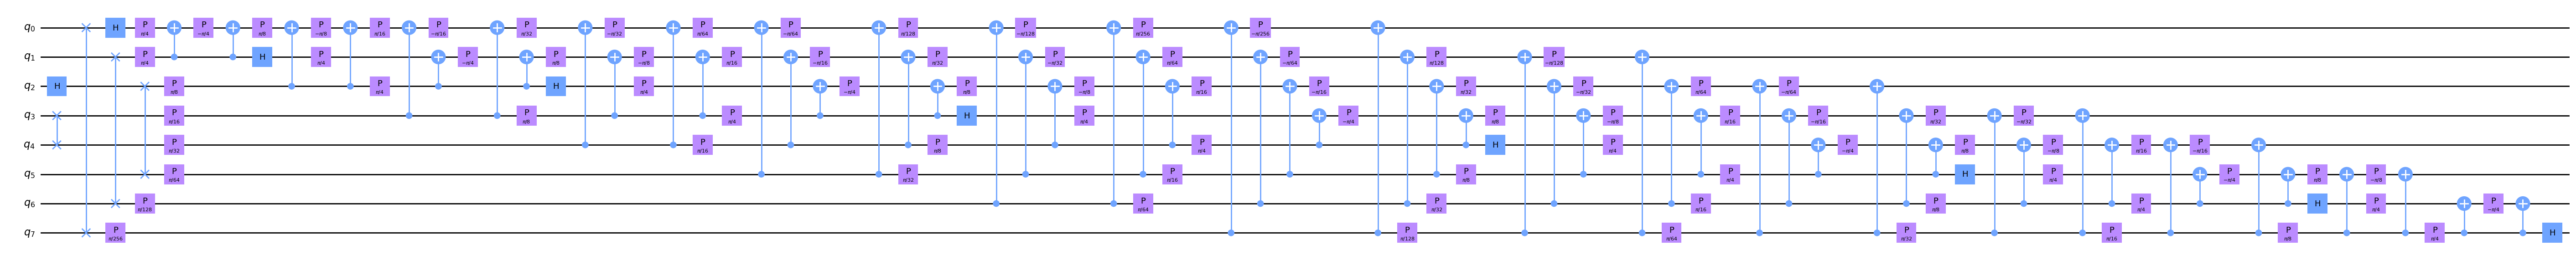

<Figure size 640x480 with 0 Axes>

In [32]:
n = 8
ac = QuantumCircuit(n)
ac.h(2)
QFT(ac, n)

probs = simulateQFT(ac, n, display_bool=True)

ac.draw(output="mpl", fold=-1)

min_n = 2, max_n = 28, min_d = 1, max_d = 27
(28, 27)
x = 2, y = 1, data = 1.6697788640876683e-34
x = 3, y = 1, data = 0.06250000000000006
x = 3, y = 2, data = 0.0
x = 4, y = 1, data = 0.03125000000000003
x = 4, y = 2, data = 3.469446951953614e-18
x = 4, y = 3, data = 6.938893903907228e-18
x = 5, y = 1, data = 0.023437500000000014
x = 5, y = 2, data = 0.007812500000000014
x = 5, y = 3, data = 3.7947076036992655e-18
x = 5, y = 4, data = 5.095750210681871e-18
x = 6, y = 1, data = 0.01171875000000001
x = 6, y = 2, data = 0.003906250000000007
x = 6, y = 3, data = 5.8817967857338616e-18
x = 6, y = 4, data = 6.152847328855238e-18
x = 6, y = 5, data = 1.734723475976807e-18
x = 7, y = 1, data = 0.006835937500000006
x = 7, y = 2, data = 0.002929687500000008
x = 7, y = 3, data = 0.0009765625000000043
x = 7, y = 4, data = 2.930733997499879e-18
x = 7, y = 5, data = 1.9786689647860456e-18
x = 7, y = 6, data = 1.2536087619363645e-18
x = 8, y = 1, data = 0.003417968750000003
x = 8, y = 2, data = 0.00

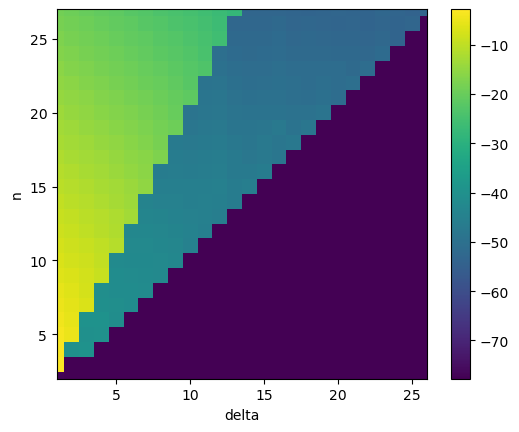

In [3]:
plotErrorsFromFile("txt/errors2-32.txt")

{'0000000010011010011': 1024}
operation count: 378
operations: {'cx': 156, 't': 88, 'tdg': 66, 'h': 44, 'measure': 19, 'u': 3, 'barrier': 2}


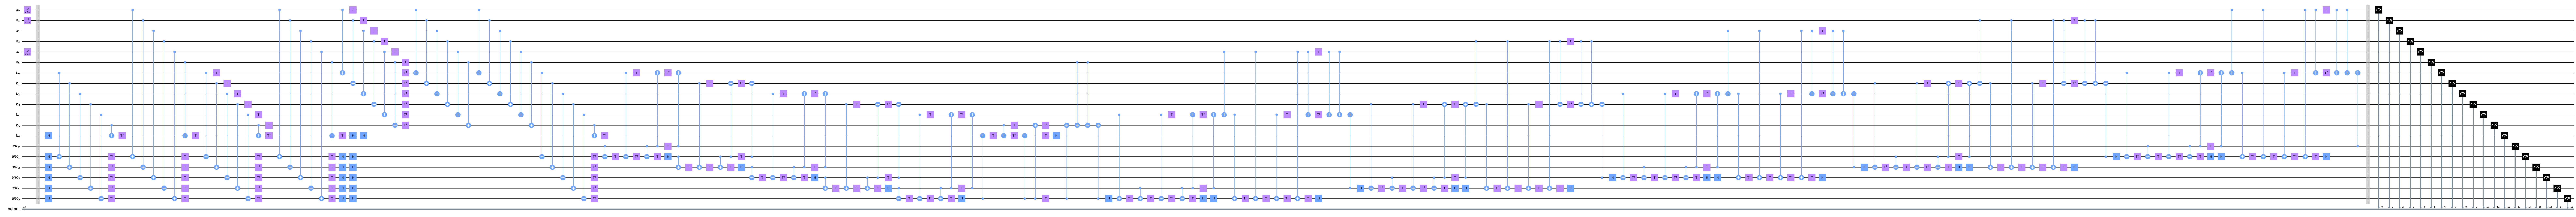

In [112]:
from qiskit import QuantumRegister, ClassicalRegister
n = 6
no_qubits = 3 * n + 1

reg_a = QuantumRegister(n, name="a")
reg_b = QuantumRegister(n + 1, name="b")
reg_anc = QuantumRegister(n, name="anc")
reg_control = QuantumRegister(2, name="control")
cr = ClassicalRegister(no_qubits, name="output")

qc = QuantumCircuit(reg_a, reg_b, reg_anc, reg_control, cr)

qc.x(0)
qc.x(1)
qc.x(4)

reverse_bool = False
qc.append(nBitAdder(n, reg_a, reg_b, reg_anc, reg_control, reverse=reverse_bool), reg_a[0:n] + reg_b[0:n + 1] + reg_anc[0:n])

qc.barrier()

qc.draw(output="mpl", fold=-1, filename="circuits/{}-bitAdder{}.png".format(n, "Reversed" if reverse_bool == True else ""))
qc.measure(range(no_qubits), range(no_qubits))

decomposed = qc.decompose(reps=3)

simulator = Aer.get_backend('qasm_simulator')
job_sim = simulator.run(qk.transpile(qc, simulator), shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
print(counts)

print("operation count: {}".format(sum(dict(decomposed.count_ops()).values())))
print("operations: {}".format(dict(decomposed.count_ops())))

decomposed.draw(output="mpl", fold=-1, filename="circuits/{}-bitAdderDecomposed{}.png".format(n, "Reversed" if reverse_bool == True else ""))

{'000000000011001100': 1024}
b_reg = 1100, int = 12


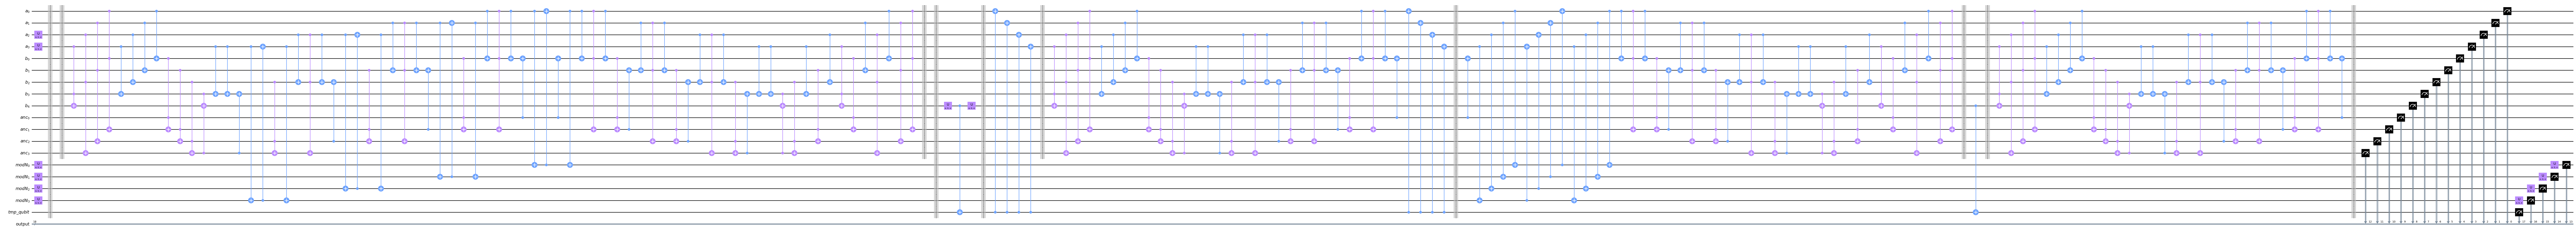

In [20]:
# n-bit adder modulo x
n = 4
no_qubits = 4 * n + 2
reverse_bool = False

arithmetic = reload(arithmetic)

reg_a = QuantumRegister(n, name="a")
reg_b = QuantumRegister(n + 1, name="b")
reg_anc = QuantumRegister(n, name="anc")
reg_N = QuantumRegister(n, name="modN")
reg_tmp_qubit = QuantumRegister(1, name="tmp_qubit")
cr = ClassicalRegister(no_qubits, name="output")

qc = QuantumCircuit(reg_a, reg_b, reg_anc, reg_N, reg_tmp_qubit, cr)

# set big N as in (mod N)
qc.x(reg_N[i] for i in range(n))

qc.x(reg_a[i] for i in (2,3))
# qc.x(reg_b[i] for i in [])

qc.append(nbitModNAdder(n, reg_a, reg_b, reg_anc, reg_N, reg_tmp_qubit), reg_a[0:n] + reg_b[0:n + 1] + reg_anc[0:n] + reg_N[0:n] + reg_tmp_qubit[0:1])

# revert N to zeros
qc.x(reg_N[i] for i in range(n))

qc.measure(range(no_qubits), range(no_qubits))

simulator = Aer.get_backend('qasm_simulator')
job_sim = simulator.run(qk.transpile(qc, simulator), shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
print(counts)

for key in counts:
    b_reg = key[(2*n+2):3*n+2]
    print("b_reg = {}, int = {}".format(b_reg, int(b_reg, 2)))

decomposed = qc.decompose(reps=3)
# qc.draw(output="mpl", fold=-1, justify='right', filename="circuits/{}-bitModularAdder{}.png".format(n, "Reversed" if reverse_bool == True else ""))
decomposed.draw(output="mpl", style="bw", fold=-1, justify='right', filename="circuits/{}-bitModularAdder{}Decomposed.png".format(n, "Reversed" if reverse_bool == True else ""))


a = 7, binMod = 0111
a = 14, binMod = 1110
a = 28, binMod = 1101
a = 56, binMod = 1011
{'00000000000100000001111': 1024}
b_reg = 0100, int = 4


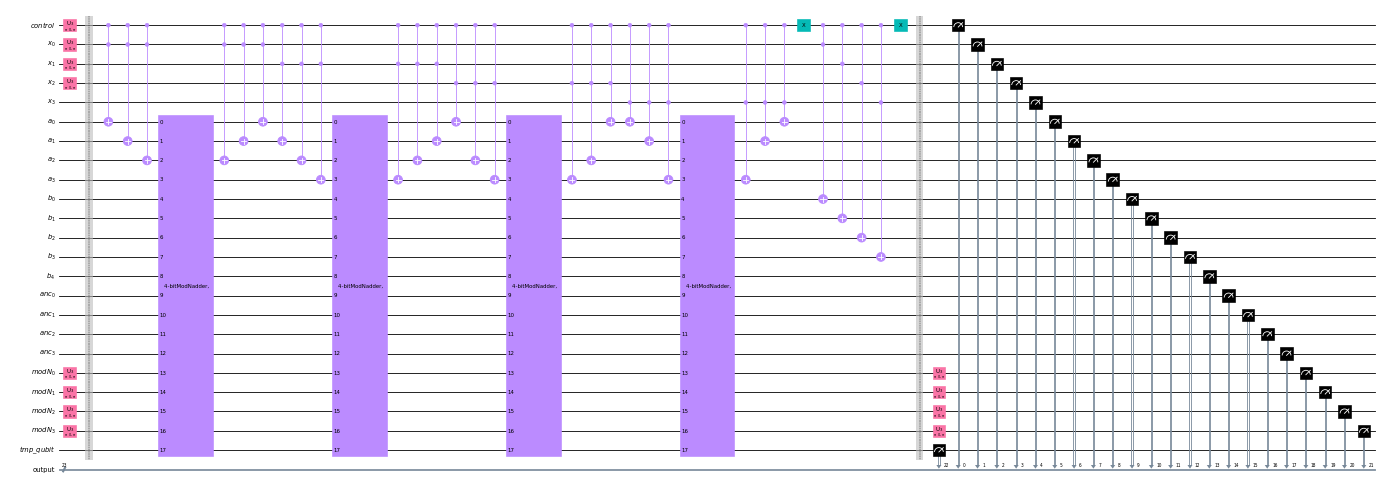

In [23]:
# modular multiplier circuit
n = 4
no_qubits = 5 * n + 3
reverse_bool = False

reg_c_qubit = QuantumRegister(1, name="control")
reg_x = QuantumRegister(n, name="x")
reg_a = QuantumRegister(n, name="a")
reg_b = QuantumRegister(n + 1, name="b")
reg_anc = QuantumRegister(n, name="anc")
reg_N = QuantumRegister(n, name="modN")
reg_tmp_qubit = QuantumRegister(1, name="tmp_qubit")
cr = ClassicalRegister(no_qubits, name="output")

qc = QuantumCircuit(reg_c_qubit, reg_x, reg_a, reg_b, reg_anc, reg_N, reg_tmp_qubit, cr)

g = 7
N = 15

# set control to 1
qc.x(reg_c_qubit[0])

# set x to 3
qc.x(reg_x[i] for i in [0,1,2])

# set N to 15
qc.x(reg_N[i] for i in range(n))


qc.append(nbitModNMultiplier(n, g, N, reg_c_qubit, reg_x, reg_a, reg_b, reg_anc, reg_N, reg_tmp_qubit, reverse=reverse_bool), reg_c_qubit[0:1] + reg_x[0:n] + reg_a[0:n] + reg_b[0:n + 1] + reg_anc[0:n] + reg_N[0:n] + reg_tmp_qubit[0:1])

# revert N to zeros
qc.x(reg_N[i] for i in range(n))

qc.measure(range(no_qubits), range(no_qubits))

simulator = Aer.get_backend('qasm_simulator')
job_sim = simulator.run(qk.transpile(qc, simulator), shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
print(counts)

for key in counts:
    b_reg = key[(2*n+2):3*n+2]
    print("b_reg = {}, int = {}".format(b_reg, int(b_reg, 2)))

reps = 1

qasm_output = qc.decompose(reps=reps).qasm()
with open("qasm_files/multiplierMod{}({}-bit)".format(N, n), 'w') as txt_file:
    txt_file.write(qasm_output)
qc.decompose(reps=reps).draw(output="mpl", fold=-1, scale=0.3, filename="circuits/{}-bitModNMultiplier{}{}".format(n, "(-1)" if reverse_bool else "", "(decomposed)" if reps > 0 else ""))

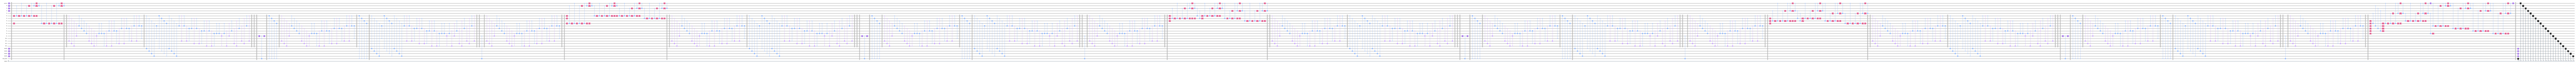

In [5]:
qc.decompose(reps=reps).draw(output="mpl", fold=-1, scale=0.3, filename="circuits/{}-bitModNMultiplier{}".format(n, "(decomposed)" if reps > 0 else ""))

a = 2, binMod = 0010
a = 4, binMod = 0100
a = 8, binMod = 1000
a = 16, binMod = 0001
a = 8, binMod = 1000
a = 16, binMod = 0001
a = 32, binMod = 0010
a = 64, binMod = 0100
a = 4, binMod = 0100
a = 8, binMod = 1000
a = 16, binMod = 0001
a = 32, binMod = 0010
a = 4, binMod = 0100
a = 8, binMod = 1000
a = 16, binMod = 0001
a = 32, binMod = 0010
a = 1, binMod = 0001
a = 2, binMod = 0010
a = 4, binMod = 0100
a = 8, binMod = 1000
a = 1, binMod = 0001
a = 2, binMod = 0010
a = 4, binMod = 0100
a = 8, binMod = 1000
a = 1, binMod = 0001
a = 2, binMod = 0010
a = 4, binMod = 0100
a = 8, binMod = 1000
a = 1, binMod = 0001
a = 2, binMod = 0010
a = 4, binMod = 0100
a = 8, binMod = 1000
000000000000000000000000000
000000000000000000000000001
000000000000000000000000010
000000000000000000000000011
000000000000000000000000100
000000000000000000000000101
000000000000000000000000110
000000000000000000000000111
000000000000000000000001000
000000000000000000000001001
000000000000000000000001010
000000000000

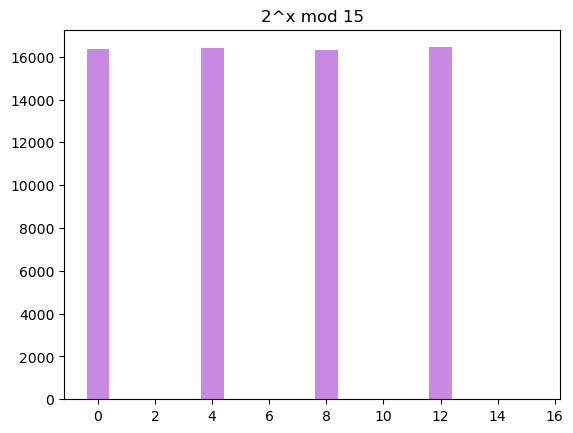

<Figure size 640x480 with 0 Axes>

In [80]:
# modular exponentiation mod N
n = 4
len_exp = n
no_qubits = len_exp + 5 * n + 3

reg_exp = QuantumRegister(len_exp, name = "reg_exp")
reg_c_qubit = QuantumRegister(1, name="reg_control")
reg_x = QuantumRegister(n, name="reg_x")
reg_a = QuantumRegister(n, name="reg_a")
reg_b = QuantumRegister(n + 1, name="reg_b")
reg_anc = QuantumRegister(n, name="reg_anc")
reg_N = QuantumRegister(n, name="reg_modN")
reg_tmp_qubit = QuantumRegister(1, name="reg_tmp_qubit")
cr = ClassicalRegister(no_qubits, name="reg_output")


g = 2

# use numpy nonzero to convert N into gates
N = 15

qc = QuantumCircuit(reg_exp, reg_c_qubit, reg_x, reg_a, reg_b, reg_anc, reg_N, reg_tmp_qubit, cr)

qc.h(reg_exp[i] for i in range(len_exp))
qc.x(reg_N[i] for i in [0,1,2,3])
qc.x(reg_x[0])

qc.append(nbitModExponentiation(n, g, N, reg_exp, reg_c_qubit, reg_x, reg_a, reg_b, reg_anc, reg_N, reg_tmp_qubit), reg_exp[0:len_exp] + reg_c_qubit[0:1] + reg_x[0:n] + reg_a[0:n] + reg_b[0:n + 1] + reg_anc[0:n] + reg_N[0:n] + reg_tmp_qubit[0:1])

qc.append(nbitQFT(len_exp, reg_exp, reversed=True), reg_exp[0:len_exp])

qc.measure(reg_exp[0:len_exp], cr[0:len_exp])
#
simulator = Aer.get_backend('qasm_simulator')
job_sim = simulator.run(qk.transpile(qc, simulator), shots=2**16)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)

plotShor(no_qubits, len_exp, counts, g, N)

# reps = 5
# qc.decompose(reps=reps).draw(output="mpl", fold=-1, scale=1, filename="circuits/{}-bitModNExponentiation{}".format(n, "(decomposed)" if reps > 0 else ""))

In [25]:
reps = 5
qasm_output = qc.decompose(reps=reps).qasm()
with open("qasm_files/ShorsAlg(N={}, g={},reps={})".format(N, g, reps), 'w') as txt_file:
    txt_file.write(qasm_output)

# qc.decompose(reps=reps).draw(output="mpl", fold=-1, scale=1, filename="circuits/{}-bitModNExponentiation{}".format(n, "(decomposed)" if reps > 0 else ""))

In [3]:
from winsound import Beep
reps = 5
qc.decompose(reps=reps).draw(output="mpl", fold=400, scale=0.4, plot_barriers=False, filename="circuits/{}-bitMod{}Exponentiation{}".format(n, N,"(decomposed)" if reps > 0 else ""))
Beep(200, 1000)